# PROJECT
4-connected grid (Manhattan distance)
input: map
output: path coordinates
References:
- Exercice 5

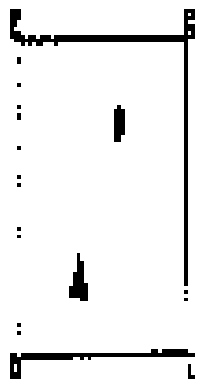

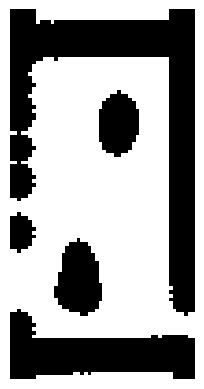

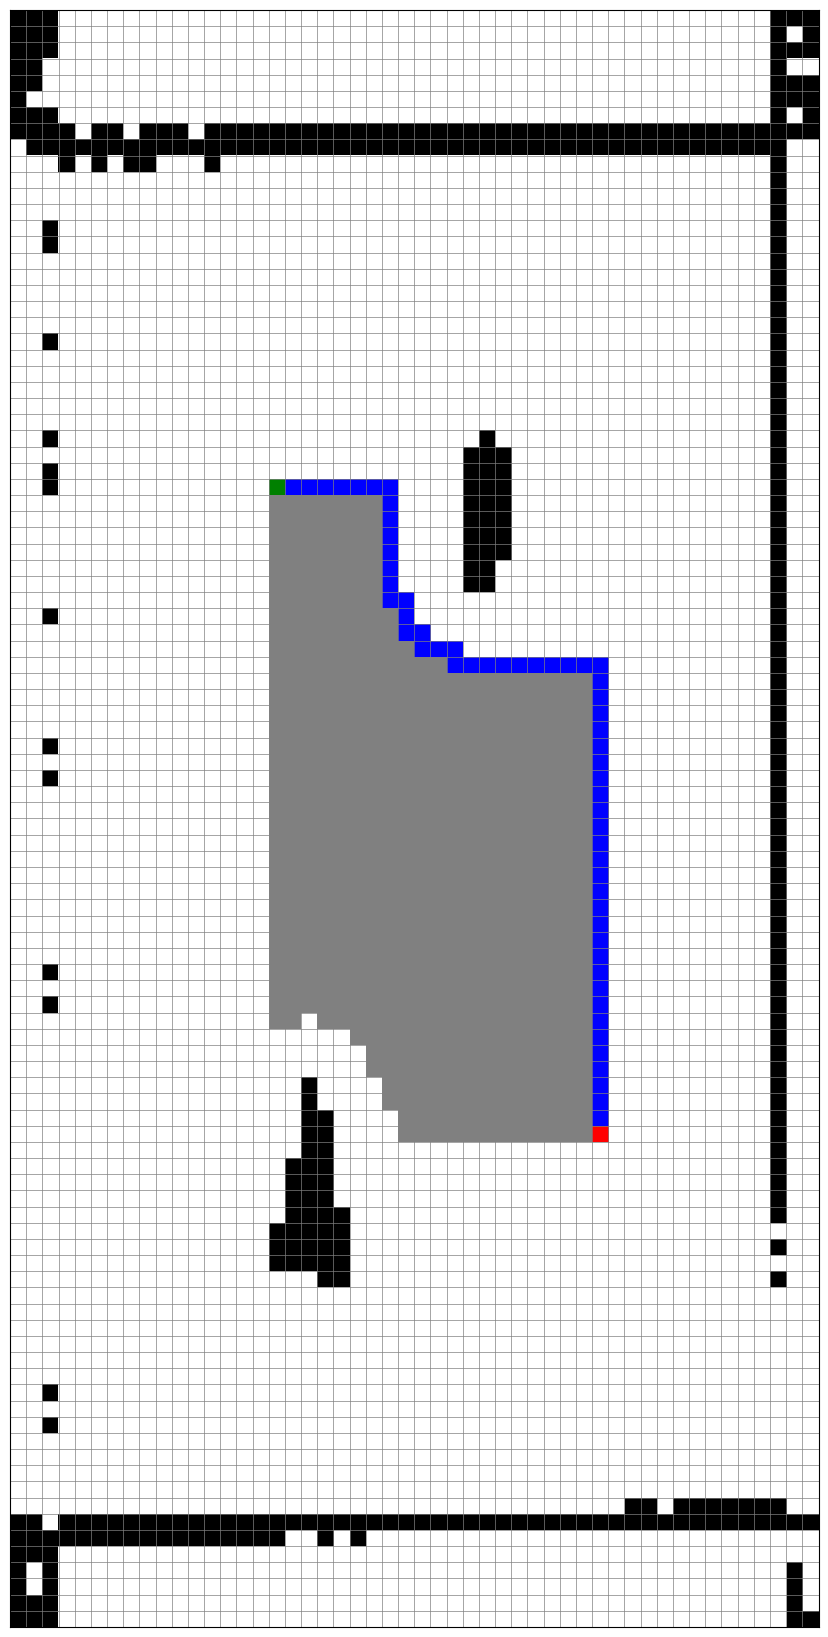

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from heapq import heappush, heappop 
import cv2

def visualization_map(path):
    # Load the text file and convert it to a image
    image = np.loadtxt(path)
    
    # Find the coordinates of the first occurrence of the digit 2, 3
    start = tuple(np.argwhere(image == 2)[0])
    goal = tuple(np.argwhere(image == 3)[0])
    
    # Replace all occurrences of the digit 2 with 0
    image[image == 2] = 0
    image[image == 3] = 0

    # conversion for display
    image = np.where(image == 0, 255, image)
    image = np.where(image == 1, 0, image)
    
    # Display the image
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

    # conversion for path planning
    image = np.where(image == 0, -1., image)
    image = np.where(image == 255, 0., image)
    return image, start, goal

def safety_distance(image, thickness):
    # Find the coordinates of all black pixels (value -1)
    black_pixels = np.argwhere(image == -1)
    image_thick = np.full_like(image, 255)
    
    # Iterate through each black pixel and draw a gray border around it
    for pixel in black_pixels:
        y, x = pixel
        cv2.circle(image_thick, (x, y), thickness, 0, -1)
    
    plt.imshow(image_thick, cmap='gray')
    plt.axis('off')
    plt.show()

    # conversion for path planning
    image_thick = np.where(image_thick == 0, -1., image_thick)
    image_thick = np.where(image_thick == 255, 0., image_thick)
    return image_thick

def heuristic(a, b):
    # Implement the Manhattan distance heuristic
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def a_star_search(map_grid, start, goal):
    # Initialize the open set as a priority queue and add the start node
    open_set = []
    heappush(open_set, (heuristic(start, goal), 0, start))  # (f_cost, g_cost, position)

    # Initialize the came_from dictionary
    came_from = {}
    # Initialize g_costs dictionary with default value of infinity and set g_costs[start] = 0
    g_costs = {start: 0}
    # Initialize the explored set
    explored = set()
    operation_count = 0

    while open_set:
        # Pop the node with the lowest f_cost from the open set
        current_f_cost, current_g_cost, current_pos = heappop(open_set)

        # Add the current node to the explored set
        explored.add(current_pos)

        # For directly reconstruct path
        if current_pos == goal:
            break

        # Get the neighbors of the current node (up, down, left, right)
        neighbors = [
            (current_pos[0] - 1, current_pos[1]),  # Up
            (current_pos[0] + 1, current_pos[1]),  # Down
            (current_pos[0], current_pos[1] - 1),  # Left
            (current_pos[0], current_pos[1] + 1)#,   # Right
            #(current_pos[0] - 1, current_pos[1] - 1),  # Up-Left
            #(current_pos[0] - 1, current_pos[1] + 1),  # Up-Right
            #(current_pos[0] + 1, current_pos[1] - 1),  # Down-Left
            #(current_pos[0] + 1, current_pos[1] + 1)   # Down-Right
        ]

        for neighbor in neighbors:
            # Check if neighbor is within bounds and not an obstacle
            if (0 <= neighbor[0] < map_grid.shape[0]) and (0 <= neighbor[1] < map_grid.shape[1]):
                if map_grid[neighbor[0], neighbor[1]] != -1 and neighbor not in explored:
                    # Determine cost for moving (diagonal or cardinal)
                    #step_cost = np.sqrt(2) if abs(neighbor[0] - current_pos[0]) == 1 and abs(neighbor[1] - current_pos[1]) == 1 else 1 #todo here
                    # Calculate tentative_g_cost
                    #tentative_g_cost = current_g_cost + step_cost + map_grid[neighbor[0], neighbor[1]] #todo here

                    
                    # Calculate tentative_g_cost
                    tentative_g_cost = current_g_cost + 1 + map_grid[neighbor[0], neighbor[1]]

                    # If this path to neighbor is better than any previous one
                    if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                        # Update came_from, g_costs, and f_cost
                        came_from[neighbor] = current_pos
                        g_costs[neighbor] = tentative_g_cost
                        f_cost = tentative_g_cost + heuristic(neighbor, goal)

                        # Add neighbor to open set
                        heappush(open_set, (f_cost, tentative_g_cost, neighbor))
                        operation_count += 1

    # Reconstruct path
    if current_pos == goal:
        path = []
        while current_pos in came_from:
            path.append(current_pos)
            current_pos = came_from[current_pos]
        path.append(start)
        return path[::-1], explored,operation_count
    else:
        # If we reach here, no path was found
        return None, explored,operation_count

def display_map(map_grid, path, start, goal, explored):
    cmap = ListedColormap(['white', 'black', 'blue', 'green', 'red', 'grey'])
    map_display = np.zeros_like(map_grid, dtype=object)

    # Assign colors based on the map grid values
    map_display[map_grid == -1] = 'black'  # Obstacles
    map_display[map_grid == 0] = 'white'   # Free space

    for position in explored:
        if map_display[tuple(position)] == 'white':
            map_display[tuple(position)] = 'grey'  # Explored cells

    # Visualize the path
    for position in path:
        if map_display[position[0], position[1]] in ['white', 'grey']:
            map_display[position[0], position[1]] = 'blue'  # Path

    #map_display[5, 3] = 'yellow' # Weighted cell
    map_display[start[0], start[1]] = 'green'  # Start
    map_display[goal[0], goal[1]] = 'red'      # Goal

    # Convert color names to numbers for plotting
    color_mapping = {'white': 0, 'black': 1, 'blue': 2, 'green': 3, 'red': 4, 'grey': 5}
    map_numeric_display = np.vectorize(color_mapping.get)(map_display)
    fig, ax = plt.subplots(figsize=(18, 21))
    ax.imshow(map_numeric_display, cmap=cmap)
    ax.set_xticks(np.arange(-0.5, map_grid.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, map_grid.shape[0], 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    #ax.set_title('a_star_search Visualization')
    plt.show()

def global_navigation(file, safety):
    image, start, goal = visualization_map(file)
    map_grid = safety_distance(image, safety)
    path, explored, operation_count = a_star_search(map_grid, start, goal)
    # Display the result
    if path:
        #print("Path found:")
        #print(f"Number of operations: {operation_count}")
        display_map(image, path, start, goal, explored) #todo here
        #return path 
    else:
        print("No path found.")

def main():
    file = "images/resized_grid_map.txt"
    safety = 4
    path = global_navigation(file, safety)

main()